<a href="https://colab.research.google.com/github/joelpawar08/All-DL-and-ML-Alogs-with-Examples/blob/master/GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

UNDERSTANDING GRU (Gated Recurrent Unit)

GRU has 2 gates:
1. Reset Gate (r): Controls how much past information to forget
2. Update Gate (z): Controls how much past information to keep

Key equations:
z_t = σ(W_z * [h_(t-1), x_t])  # Update gate
r_t = σ(W_r * [h_(t-1), x_t])  # Reset gate
h̃_t = tanh(W * [r_t * h_(t-1), x_t])  # Candidate hidden state
h_t = (1 - z_t) * h_(t-1) + z_t * h̃_t  # Final hidden state


--- PART 1: Generating Sine Wave Data ---


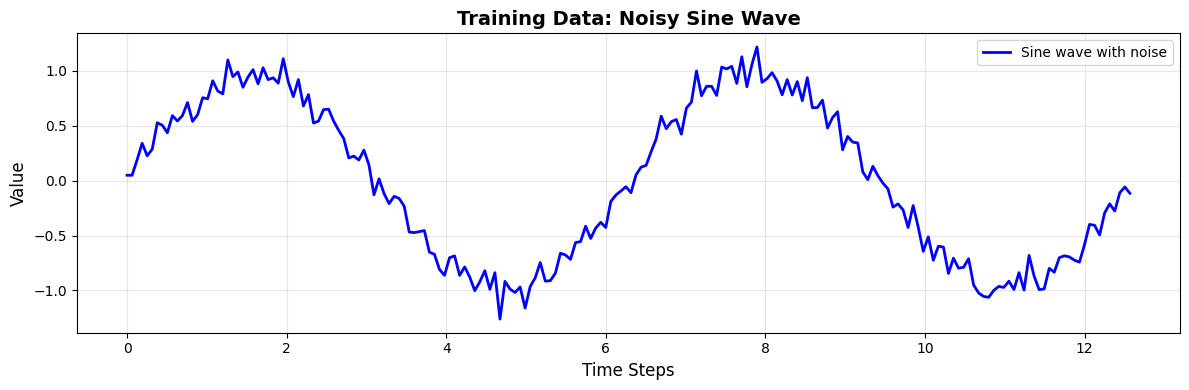

Generated 200 data points

--- PART 2: Preparing Sequences ---
Input shape: (190, 10)
Output shape: (190,)

Example: Using 10 values to predict the next value

Training samples: 152
Testing samples: 38

--- PART 3: Building GRU Model ---

Model Architecture:
GRUModel(
  (gru): GRU(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

Total parameters: 3393

--- PART 4: Training the GRU ---
Epoch [20/100], Train Loss: 0.024667, Test Loss: 0.040950
Epoch [40/100], Train Loss: 0.004473, Test Loss: 0.004814
Epoch [60/100], Train Loss: 0.003356, Test Loss: 0.002464
Epoch [80/100], Train Loss: 0.002943, Test Loss: 0.002573
Epoch [100/100], Train Loss: 0.002843, Test Loss: 0.002302

Training completed!

--- PART 5: Visualizing Results ---


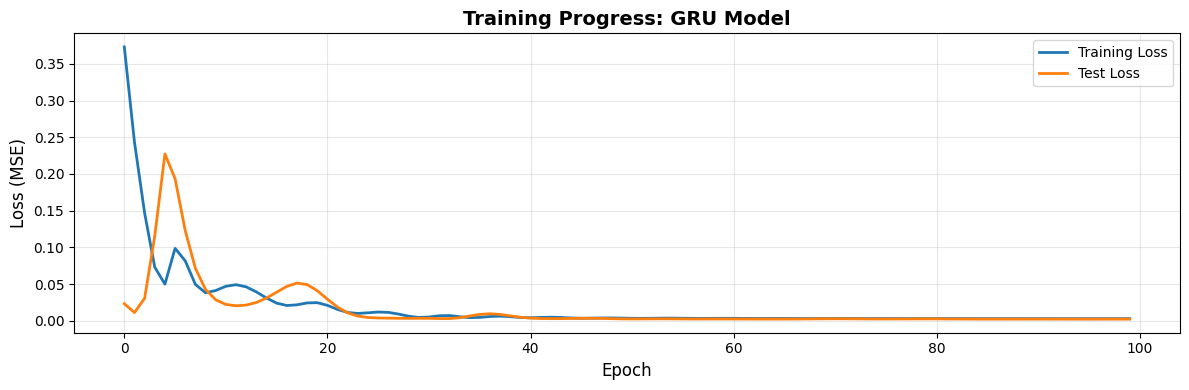

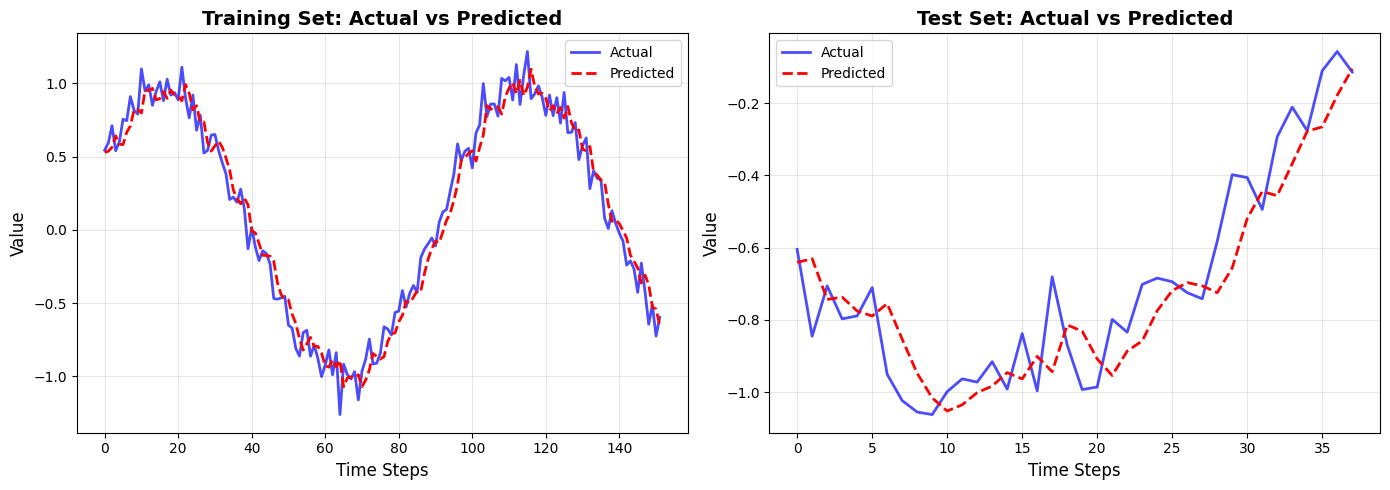


Final Results:
Training MSE: 0.017462
Test MSE: 0.014154

--- PART 7: Understanding GRU Internal Workings ---


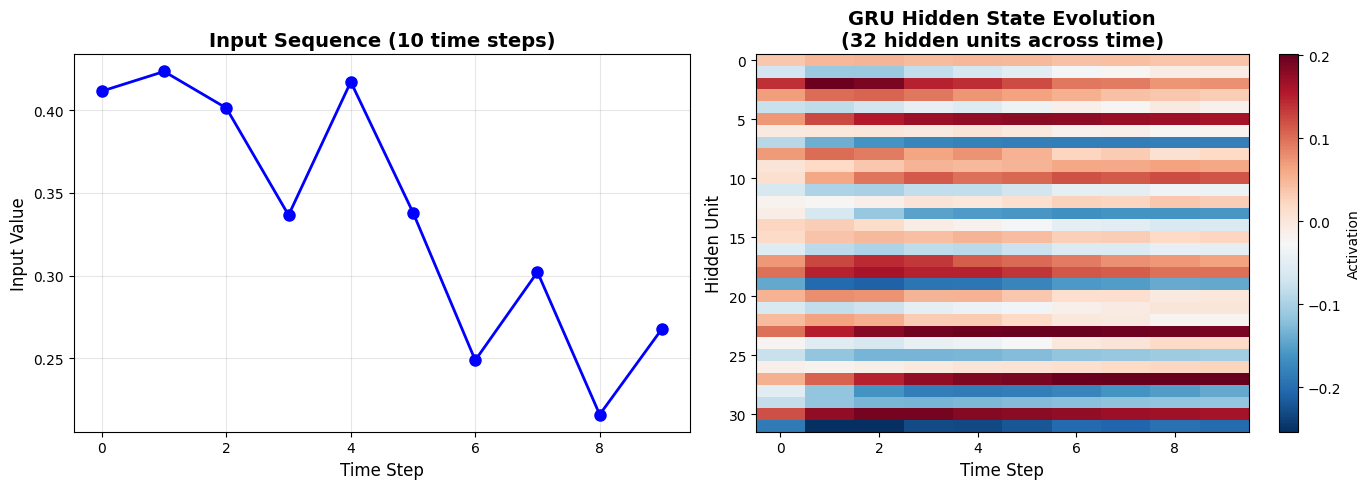


The heatmap shows how 32 hidden units in the GRU evolve over time
Each column represents one time step, each row represents one hidden unit
Colors indicate activation strength (red=positive, blue=negative)

SUMMARY:
✓ GRU successfully learned to predict the sine wave pattern
✓ Update gate (z) controls information flow from previous hidden state
✓ Reset gate (r) controls how much past information to forget
✓ GRU is simpler than LSTM (2 gates vs 3) but often performs similarly
✓ Perfect for sequence tasks: time series, NLP, speech recognition


In [1]:
"""
GRU (Gated Recurrent Unit) - Complete Tutorial with Visualizations
This notebook demonstrates how GRU works using a simple sequence prediction task
"""

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("=" * 60)
print("UNDERSTANDING GRU (Gated Recurrent Unit)")
print("=" * 60)
print("\nGRU has 2 gates:")
print("1. Reset Gate (r): Controls how much past information to forget")
print("2. Update Gate (z): Controls how much past information to keep")
print("\nKey equations:")
print("z_t = σ(W_z * [h_(t-1), x_t])  # Update gate")
print("r_t = σ(W_r * [h_(t-1), x_t])  # Reset gate")
print("h̃_t = tanh(W * [r_t * h_(t-1), x_t])  # Candidate hidden state")
print("h_t = (1 - z_t) * h_(t-1) + z_t * h̃_t  # Final hidden state")
print("=" * 60)

# ============================================================================
# PART 1: Generate Synthetic Time Series Data
# ============================================================================
print("\n\n--- PART 1: Generating Sine Wave Data ---")

# Generate a sine wave with some noise
def generate_sine_wave(n_points=200):
    """Generate a noisy sine wave for sequence prediction"""
    x = np.linspace(0, 4 * np.pi, n_points)
    y = np.sin(x) + 0.1 * np.random.randn(n_points)
    return x, y

x_data, y_data = generate_sine_wave()

# Visualize the data
plt.figure(figsize=(12, 4))
plt.plot(x_data, y_data, 'b-', linewidth=2, label='Sine wave with noise')
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.title('Training Data: Noisy Sine Wave', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Generated {len(y_data)} data points")

# ============================================================================
# PART 2: Prepare Data for GRU
# ============================================================================
print("\n--- PART 2: Preparing Sequences ---")

def create_sequences(data, seq_length):
    """
    Create input-output sequences for training
    Given a sequence, predict the next value

    Example: If seq_length=5 and data=[1,2,3,4,5,6,7]
    X: [[1,2,3,4,5], [2,3,4,5,6]]
    y: [6, 7]
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Normalize data to [0, 1] range for better training
scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y_data.reshape(-1, 1)).flatten()

# Create sequences (use 10 previous points to predict the next)
SEQ_LENGTH = 10
X, y = create_sequences(y_scaled, SEQ_LENGTH)

print(f"Input shape: {X.shape}")  # (samples, sequence_length)
print(f"Output shape: {y.shape}")  # (samples,)
print(f"\nExample: Using {SEQ_LENGTH} values to predict the next value")

# Split into train and test sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train).unsqueeze(-1)  # Shape: (batch, seq, features)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test).unsqueeze(-1)
y_test = torch.FloatTensor(y_test)

print(f"\nTraining samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

# ============================================================================
# PART 3: Define GRU Model
# ============================================================================
print("\n--- PART 3: Building GRU Model ---")

class GRUModel(nn.Module):
    """
    Simple GRU model for time series prediction

    Architecture:
    - GRU layer: Processes sequences and captures temporal dependencies
    - Fully connected layer: Maps GRU output to prediction
    """
    def __init__(self, input_size=1, hidden_size=32, num_layers=1, output_size=1):
        super(GRUModel, self).__init__()

        # GRU layer
        # input_size: Number of features per time step
        # hidden_size: Number of features in the hidden state
        # num_layers: Number of stacked GRU layers
        # batch_first=True: Input shape is (batch, seq, features)
        self.gru = nn.GRU(input_size, hidden_size, num_layers,
                         batch_first=True)

        # Fully connected layer to produce output
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_size)

        # GRU forward pass
        # out shape: (batch_size, sequence_length, hidden_size)
        # h_n shape: (num_layers, batch_size, hidden_size)
        out, h_n = self.gru(x)

        # Take the output from the last time step
        # out[:, -1, :] shape: (batch_size, hidden_size)
        out = self.fc(out[:, -1, :])

        return out

# Initialize model
model = GRUModel(input_size=1, hidden_size=32, num_layers=1)
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

print(f"\nModel Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")

# ============================================================================
# PART 4: Train the GRU
# ============================================================================
print("\n--- PART 4: Training the GRU ---")

num_epochs = 100
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    # Training
    model.train()
    optimizer.zero_grad()

    # Forward pass
    y_pred = model(X_train)
    loss = criterion(y_pred.squeeze(), y_train)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    # Evaluation on test set
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test)
        test_loss = criterion(y_pred_test.squeeze(), y_test)
        test_losses.append(test_loss.item())

    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {loss.item():.6f}, "
              f"Test Loss: {test_loss.item():.6f}")

print("\nTraining completed!")

# ============================================================================
# PART 5: Visualize Training Progress
# ============================================================================
print("\n--- PART 5: Visualizing Results ---")

# Plot training and test loss
plt.figure(figsize=(12, 4))
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(test_losses, label='Test Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training Progress: GRU Model', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================================
# PART 6: Make Predictions and Visualize
# ============================================================================

# Get predictions for the entire dataset
model.eval()
with torch.no_grad():
    # Predict on training data
    train_predict = model(X_train).squeeze().numpy()
    # Predict on test data
    test_predict = model(X_test).squeeze().numpy()

# Inverse transform to original scale
train_predict = scaler.inverse_transform(train_predict.reshape(-1, 1)).flatten()
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1)).flatten()
y_train_orig = scaler.inverse_transform(y_train.numpy().reshape(-1, 1)).flatten()
y_test_orig = scaler.inverse_transform(y_test.numpy().reshape(-1, 1)).flatten()

# Plot predictions vs actual values
plt.figure(figsize=(14, 5))

# Training data
plt.subplot(1, 2, 1)
plt.plot(y_train_orig, 'b-', label='Actual', linewidth=2, alpha=0.7)
plt.plot(train_predict, 'r--', label='Predicted', linewidth=2)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.title('Training Set: Actual vs Predicted', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Test data
plt.subplot(1, 2, 2)
plt.plot(y_test_orig, 'b-', label='Actual', linewidth=2, alpha=0.7)
plt.plot(test_predict, 'r--', label='Predicted', linewidth=2)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.title('Test Set: Actual vs Predicted', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate and print metrics
train_mse = np.mean((y_train_orig - train_predict) ** 2)
test_mse = np.mean((y_test_orig - test_predict) ** 2)

print(f"\nFinal Results:")
print(f"Training MSE: {train_mse:.6f}")
print(f"Test MSE: {test_mse:.6f}")

# ============================================================================
# PART 7: Visualize How GRU Processes Sequences
# ============================================================================
print("\n--- PART 7: Understanding GRU Internal Workings ---")

# Take one sample and visualize the hidden states
sample_input = X_test[0:1]  # Shape: (1, seq_length, 1)

model.eval()
with torch.no_grad():
    # Get hidden states at each time step
    gru_out, _ = model.gru(sample_input)  # Shape: (1, seq_length, hidden_size)
    hidden_states = gru_out.squeeze().numpy()  # Shape: (seq_length, hidden_size)

# Plot hidden state evolution
plt.figure(figsize=(14, 5))

# Plot input sequence
plt.subplot(1, 2, 1)
input_seq = sample_input.squeeze().numpy()
plt.plot(input_seq, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Input Value', fontsize=12)
plt.title('Input Sequence (10 time steps)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Plot hidden state activations as heatmap
plt.subplot(1, 2, 2)
plt.imshow(hidden_states.T, aspect='auto', cmap='RdBu_r', interpolation='nearest')
plt.colorbar(label='Activation')
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Hidden Unit', fontsize=12)
plt.title('GRU Hidden State Evolution\n(32 hidden units across time)',
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nThe heatmap shows how 32 hidden units in the GRU evolve over time")
print("Each column represents one time step, each row represents one hidden unit")
print("Colors indicate activation strength (red=positive, blue=negative)")

print("\n" + "=" * 60)
print("SUMMARY:")
print("=" * 60)
print("✓ GRU successfully learned to predict the sine wave pattern")
print("✓ Update gate (z) controls information flow from previous hidden state")
print("✓ Reset gate (r) controls how much past information to forget")
print("✓ GRU is simpler than LSTM (2 gates vs 3) but often performs similarly")
print("✓ Perfect for sequence tasks: time series, NLP, speech recognition")
print("=" * 60)